In [1]:
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, RandomElasticTransform, RandomRotation, RandomZoom
from keras.models import Sequential

2025-05-25 14:20:26.770923: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 14:20:26.771372: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-25 14:20:26.773716: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-25 14:20:26.779854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748204426.789512   49614 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748204426.79

In [2]:
data: tf.data.Dataset = image_dataset_from_directory(
    "notes/training", color_mode="grayscale", image_size=(64, 64)
)
class_names = data.class_names

augmentation = Sequential([
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomElasticTransform(0.1)
])

def augment_images(image, label):
    image = augmentation(image)
    return image, label

data = data.map(augment_images)

Found 4000 files belonging to 5 classes.


E0000 00:00:1748204428.923997   49614 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748204428.924300   49614 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


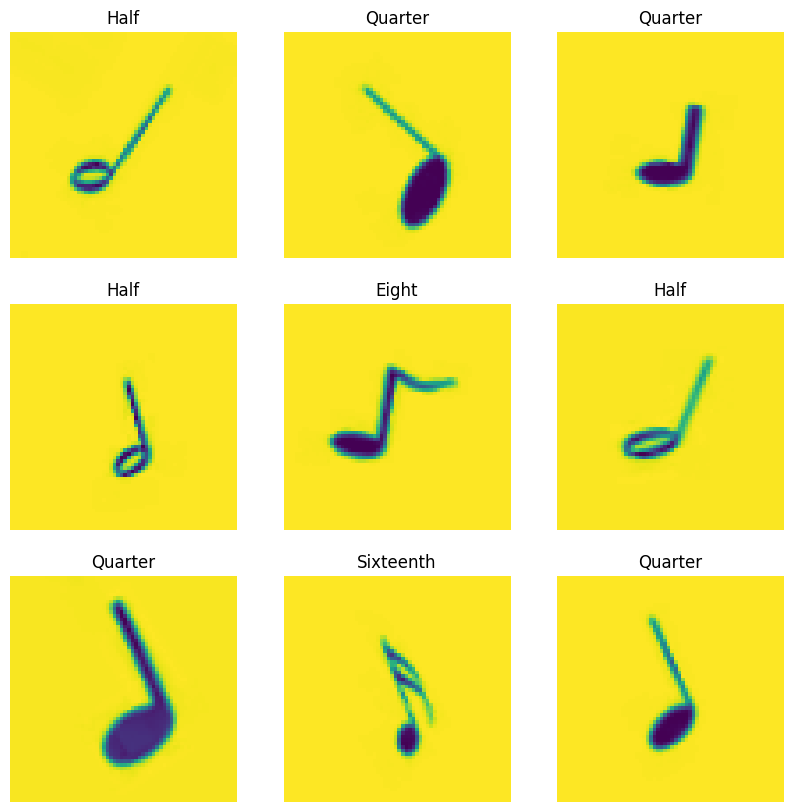

In [11]:
for images, labels in data.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [4]:
model = Sequential(
    [
        Conv2D(
            8, kernel_size=3, padding="same", activation="relu", input_shape=(64, 64, 1)
        ),
        MaxPooling2D((2, 2)),
        Conv2D(16, kernel_size=3, padding="same", activation="relu"),
        MaxPooling2D(16, 16),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(5, activation="softmax"),
    ]
)

model.summary()

/home/printchard/workspace/tc3002b/ml-note-detection/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,733 (22.39 KB)

 Trainable params: 5,733 (22.39 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
train_dataset = data.prefetch(buffer_size=tf.data.AUTOTUNE)
def scale_images(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(scale_images)

In [6]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(train_dataset, epochs=15)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2795 - loss: 1.5468
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6581 - loss: 0.9320
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7615 - loss: 0.6851
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7935 - loss: 0.5700
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8369 - loss: 0.5054
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8741 - loss: 0.4306
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8930 - loss: 0.3985
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8810 - loss: 0.4170
Epoch 9/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9065 - loss: 0.3931
Epoch 10/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9112 - loss: 0.3666
Epoch 11/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9193 - loss: 0.3595
Epoch 12/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/ste

In [7]:
test_data: tf.data.Dataset = image_dataset_from_directory(
    "notes/test", color_mode="grayscale", image_size=(64, 64)
)

test_dataset = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

Found 1000 files belonging to 5 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8981 - loss: 18.8685
Test loss: 23.307395935058594
Test accuracy: 0.8999999761581421


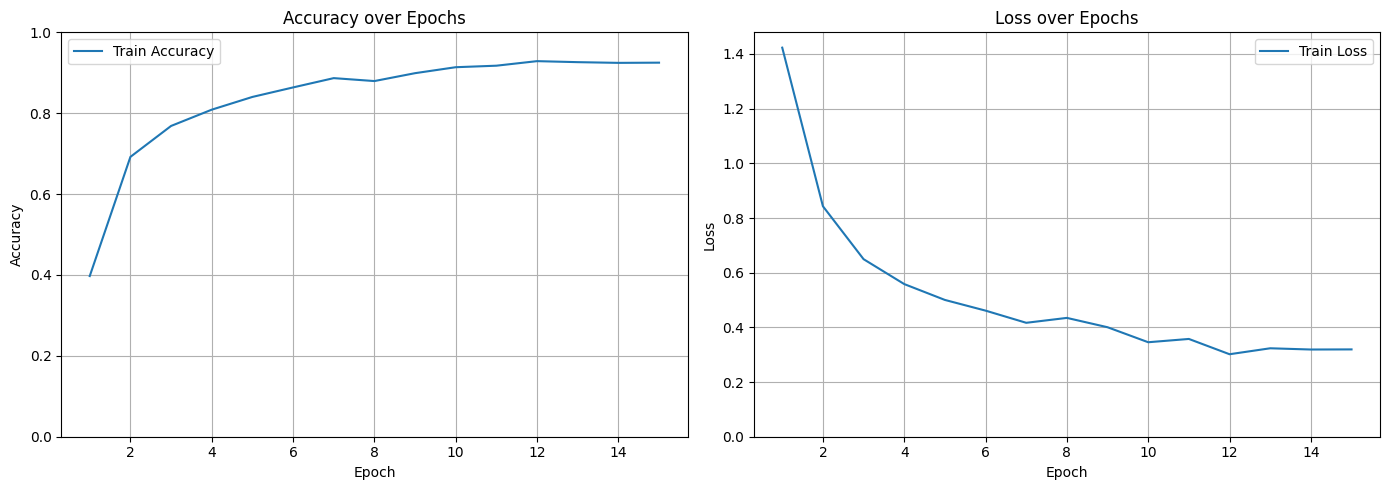

In [8]:
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
train_loss = history.history['loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(epochs, train_acc, label='Train Accuracy')
ax1.set_title('Accuracy over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(epochs, train_loss, label='Train Loss')
ax2.set_title('Loss over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_ylim(0, ax2.get_ylim()[1])
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


2025-05-25 14:20:44.306413: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


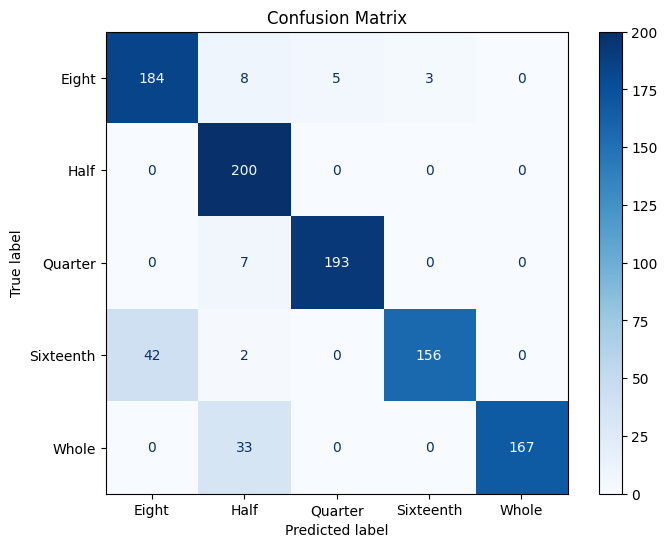

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

all_images = []
all_labels = []
for images, labels in test_data:
    all_images.append(images)
    all_labels.append(labels)
X_test = np.concatenate(all_images)
y_true = np.concatenate(all_labels)


pred_probs = model.predict(X_test)
y_pred = np.argmax(pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [10]:
model.save_weights('note_detection.weights.h5')